In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

# 경고 뜨지 않게..
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 모듈 
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# CNN : 커널을 통해 합성곱을 구하는 것. 이미지의 특징이 두드러 지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다.
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D
# Flatten : 다차원의 이미지 데이터를 선형 회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는 것
from tensorflow.keras.layers import Flatten
# Dropout : 이미지나 영상, 음파 등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는 것을 예방하고
# 오랫동한 학습이 진행될 수 있도록 한다.
from tensorflow.keras.layers import Dropout
# Embedding : 단어의 수를 조정한다.
from tensorflow.keras.layers import Embedding

# LSTM
from tensorflow.keras.layers import LSTM



# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical

# 저장된 학습모델을 복원한다.
from tensorflow.keras.models import load_model

# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping

# 문장을 잘라준다.
from tensorflow.keras.preprocessing.text import Tokenizer
# 모든 문장 데이터의 단어 데이터의 수를 동일한 수로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문자열을 가지고 단어 사전을 만들어준다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence



# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split

# 랜덤시드 설정
# 데이터를 랜덤하게 섞거나 가중치를 랜덤하게 설정하는 등..
# 작업에서 랜덤을 적용하는 경우가 더러 있다.
# 이에, 시드를 고정시킨다.
random_seed = 1

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu가 있다면...
if len(gpus) > 0 :
    try :
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e :
        print(e)

### 데이터를 불러온다.

In [2]:
# 데이터를 읽어온다.
df1 = pd.read_csv('./data/06_data.csv')
df1

,팀1이름,팀2이름,팀1점수,팀2점수
0,롯데,한화,11,1
1,LG,SK,4,5
2,KIA,삼성,3,4
3,롯데,한화,9,8
4,넥센,두산,1,4
...,...,...,...,...
9508,삼성,두산,3,11
9509,두산,KT,2,4
9510,두산,KT,1,6
9511,KT,두산,3,1


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9513 entries, 0 to 9512
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   팀1이름    9513 non-null   object
 1   팀2이름    9513 non-null   object
 2   팀1점수    9513 non-null   int64 
 3   팀2점수    9513 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 297.4+ KB


In [4]:
# 결측치 확인
df1.isna().sum()

팀1이름    0
팀2이름    0
팀1점수    0
팀2점수    0
dtype: int64

### 각 팀별 승률을 확인해본다.

In [5]:
df1

,팀1이름,팀2이름,팀1점수,팀2점수
0,롯데,한화,11,1
1,LG,SK,4,5
2,KIA,삼성,3,4
3,롯데,한화,9,8
4,넥센,두산,1,4
...,...,...,...,...
9508,삼성,두산,3,11
9509,두산,KT,2,4
9510,두산,KT,1,6
9511,KT,두산,3,1


In [6]:
# 데이터 프레임을 복제한다.
df2 = df1.copy()
# 컬럼 이름을 변경한다.
df2.columns = ['팀2이름', '팀1이름', '팀2점수', '팀1점수']
df2

,팀2이름,팀1이름,팀2점수,팀1점수
0,롯데,한화,11,1
1,LG,SK,4,5
2,KIA,삼성,3,4
3,롯데,한화,9,8
4,넥센,두산,1,4
...,...,...,...,...
9508,삼성,두산,3,11
9509,두산,KT,2,4
9510,두산,KT,1,6
9511,KT,두산,3,1


In [7]:
# 두 데이터 프레임을 합친다.
df3 = pd.concat([df1, df2])
df3.reset_index(inplace=True, drop=True)
df3

,팀1이름,팀2이름,팀1점수,팀2점수
0,롯데,한화,11,1
1,LG,SK,4,5
2,KIA,삼성,3,4
3,롯데,한화,9,8
4,넥센,두산,1,4
...,...,...,...,...
19021,두산,삼성,11,3
19022,KT,두산,4,2
19023,KT,두산,6,1
19024,두산,KT,1,3


In [8]:
# 경기 결과를 가지고 있는 컬럼을 추가한다.
df3['승리여부'] = 0
df3

,팀1이름,팀2이름,팀1점수,팀2점수,승리여부
0,롯데,한화,11,1,0
1,LG,SK,4,5,0
2,KIA,삼성,3,4,0
3,롯데,한화,9,8,0
4,넥센,두산,1,4,0
...,...,...,...,...,...
19021,두산,삼성,11,3,0
19022,KT,두산,4,2,0
19023,KT,두산,6,1,0
19024,두산,KT,1,3,0


In [9]:
# 이긴 경기는 승리여부를 1로 채워준다.
idx1 = df3.query('팀1점수 > 팀2점수').index
df3.loc[idx1, '승리여부'] = 1
df3

,팀1이름,팀2이름,팀1점수,팀2점수,승리여부
0,롯데,한화,11,1,1
1,LG,SK,4,5,0
2,KIA,삼성,3,4,0
3,롯데,한화,9,8,1
4,넥센,두산,1,4,0
...,...,...,...,...,...
19021,두산,삼성,11,3,1
19022,KT,두산,4,2,1
19023,KT,두산,6,1,1
19024,두산,KT,1,3,0


In [10]:
# 팀1이름을 확인한다.
df3['팀1이름'].value_counts()

두산     2131
삼성     2070
LG     2058
롯데     2052
KIA    2039
한화     2029
SK     1933
NC     1389
넥센     1194
키움      878
KT      595
kt      486
SSG     152
드림        7
나눔        7
웨스턴       3
이스턴       3
Name: 팀1이름, dtype: int64

In [11]:
# 팀 이름 정제
idx1 = df3.query('팀1이름 == "SK" or 팀1이름 == "SSG"').index
df3.loc[idx1, '팀1이름'] = 'SK_SSG'

idx2 = df3.query('팀1이름 == "넥센" or 팀1이름 == "키움"').index
df3.loc[idx2, '팀1이름'] = '넥센_키움'

idx3 = df3.query('팀1이름 == "kt" or 팀1이름 == "KT"').index
df3.loc[idx3, '팀1이름'] = 'KT'

a1 = ['드림', '나눔', '웨스턴', '이스턴']
idx4 = df3.query('팀1이름 in @a1').index
df3.drop(idx4, inplace=True)

df3['팀1이름'].value_counts()

두산        2131
SK_SSG    2085
넥센_키움     2072
삼성        2070
LG        2058
롯데        2052
KIA       2039
한화        2029
NC        1389
KT        1081
Name: 팀1이름, dtype: int64

In [12]:
# 팀 이름 정제
idx1 = df3.query('팀2이름 == "SK" or 팀2이름 == "SSG"').index
df3.loc[idx1, '팀2이름'] = 'SK_SSG'

idx2 = df3.query('팀2이름 == "넥센" or 팀2이름 == "키움"').index
df3.loc[idx2, '팀2이름'] = '넥센_키움'

idx3 = df3.query('팀2이름 == "kt" or 팀2이름 == "KT"').index
df3.loc[idx3, '팀2이름'] = 'KT'

a1 = ['드림', '나눔', '웨스턴', '이스턴']
idx4 = df3.query('팀2이름 in @a1').index
df3.drop(idx4, inplace=True)

df3['팀2이름'].value_counts()

두산        2131
SK_SSG    2085
넥센_키움     2072
삼성        2070
LG        2058
롯데        2052
KIA       2039
한화        2029
NC        1389
KT        1081
Name: 팀2이름, dtype: int64

In [13]:
# 각 팀별로 경기 횟수를 구한다.
a1 = df3['팀1이름'].value_counts()
a1.sort_index(inplace=True)
a1

KIA       2039
KT        1081
LG        2058
NC        1389
SK_SSG    2085
넥센_키움     2072
두산        2131
롯데        2052
삼성        2070
한화        2029
Name: 팀1이름, dtype: int64

In [14]:
# 각 팀별로 승리 횟수를 구한다.
a2 = df3.groupby('팀1이름')['승리여부'].sum()
a2

팀1이름
KIA        976
KT         483
LG         967
NC         701
SK_SSG    1077
넥센_키움     1021
두산        1162
롯데         977
삼성        1051
한화         828
Name: 승리여부, dtype: int64

In [15]:
# 승률을 구하기 위해 나눈다.
a3 = a2 / a1
a3 = a3 * 100
a3

팀1이름
KIA       47.866601
KT        44.680851
LG        46.987366
NC        50.467963
SK_SSG    51.654676
넥센_키움     49.276062
두산        54.528390
롯데        47.612086
삼성        50.772947
한화        40.808280
dtype: float64

In [16]:
a4 = pd.DataFrame(a3)
a4.reset_index(inplace=True)
a4.columns = ['팀', '승률']
a4.sort_values(by='승률', ascending=False, inplace=True)
a4

,팀,승률
6,두산,54.528390
4,SK_SSG,51.654676
8,삼성,50.772947
3,NC,50.467963
5,넥센_키움,49.276062
0,KIA,47.866601
7,롯데,47.612086
2,LG,46.987366
1,KT,44.680851
9,한화,40.808280


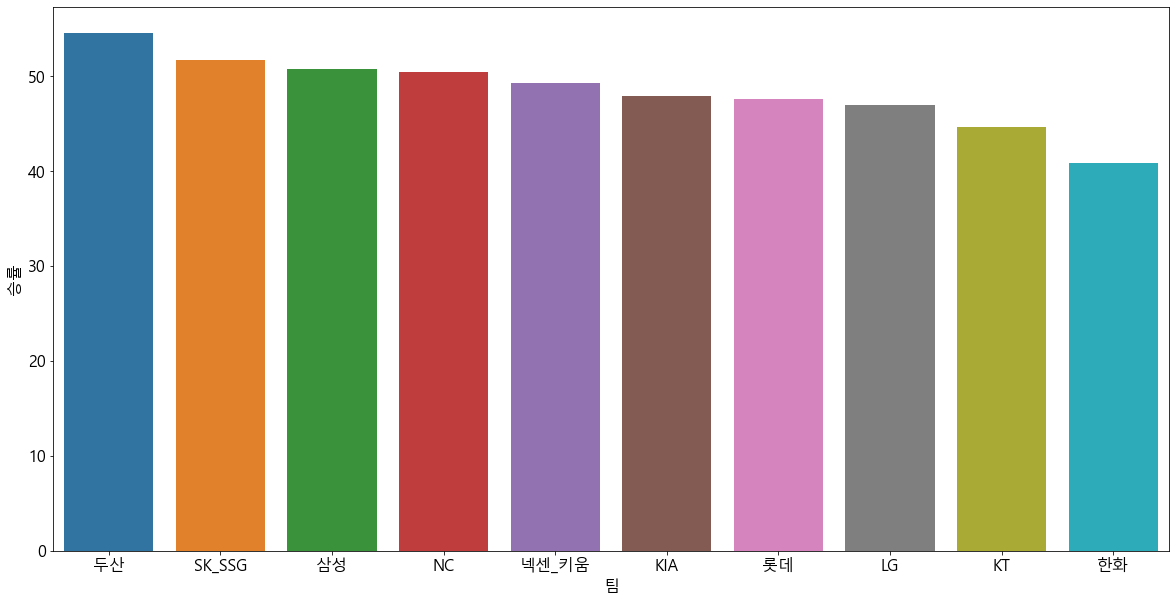

In [18]:
sns.barplot(data=a4, x='팀', y='승률')
plt.show()